# **Dynamic Selection Hybrid Model for Advancing Thyroid Care With BOOST Balancing Method**

======================================================================================================================================

#### Overview of the code:

1. Data collection

2. Analyze the data

3. Daata preprocessing
    * Drop unwanted columns and duplicates
    * Handle Null values
        * Drop if it contains more than 50% null values
        * Fill or replace null values with mean, median or mode.
    * Implement BOOST balancing method to balance the data.

        BOOST :=>
        - BS(Boosting with Sample Weighting), 
        - SMOTE (Synthetic Minority Over-sampling Technique),
        - Tomek Links (TL)
        
        implementation:
        - Split dataset into training and test sets
        - Step 1: Apply Boosting Stage (BS)
        - Step 2: Apply SMOTE for oversampling minority class
        - Step 3: Apply Tomek Links to remove noisy samples
        - Convert the resampled data into DataFrame
    * Implement Labelencoding to convert object type columns into numeric columns.

4. Data Splitting

5. Build a Dynamic Selection Hybrid Model

    implementation:
    
    * Define the classifiers
    * Step 1: Train all classifiers and compute Permutation Feature Importance (PFI)
    * Step 2: Select Half-Most Effective Classifiers (HEC) based on PFI
    * Step 3: Define the ensemble methods using the selected classifiers
    * Step 4: Train each ensemble method and evaluate accuracy
    * Step 5: Select Most Efficient Ensemble Method (EEM)
    * Build final model

6. Save the model for deploy into web application frontend

7. sample predictions

======================================================================================================================================

#

### Import necessary libraries

In [461]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from IPython.display import display, HTML

# # Data Collection

In [462]:
# Read the dataset and store it a a dataframe
df = pd.read_csv("DATASET/thyroidDF.csv")

### Analyze the data

In [463]:
# View the dataframe
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,63,F,t,f,f,t,f,f,f,f,...,48.0,t,1.02,t,47.0,f,NaN,other,F,840815067
1,75,F,f,f,f,f,f,f,f,f,...,157.0,t,0.89,t,176.0,f,NaN,SVI,A,840816008
2,41,F,f,f,f,f,f,f,f,f,...,33.0,t,1.07,t,31.0,f,NaN,other,F,840816061
3,61,M,f,f,f,t,f,f,f,f,...,114.0,t,0.84,t,136.0,f,NaN,other,G,840817062
4,27,F,f,f,f,f,f,f,f,f,...,7.5,t,0.94,t,7.5,f,NaN,other,F,840820014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,72,F,f,f,f,f,f,f,f,t,...,16.0,t,1.10,t,15.0,f,NaN,other,E,861020023
916,72,M,f,f,f,f,f,f,f,t,...,16.0,t,1.10,t,15.0,f,NaN,other,E,861020023
917,72,F,f,f,f,f,f,f,f,t,...,16.0,t,1.10,t,15.0,f,NaN,other,E,861020023
918,72,M,f,f,f,f,f,f,f,t,...,16.0,t,1.10,t,15.0,f,NaN,other,E,861020023


In [464]:
# Count rows, columns
df.shape

(920, 31)

In [465]:
# Information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  920 non-null    int64  
 1   sex                  878 non-null    object 
 2   on_thyroxine         920 non-null    object 
 3   query_on_thyroxine   920 non-null    object 
 4   on_antithyroid_meds  920 non-null    object 
 5   sick                 920 non-null    object 
 6   pregnant             920 non-null    object 
 7   thyroid_surgery      920 non-null    object 
 8   I131_treatment       920 non-null    object 
 9   query_hypothyroid    920 non-null    object 
 10  query_hyperthyroid   920 non-null    object 
 11  lithium              920 non-null    object 
 12  goitre               920 non-null    object 
 13  tumor                920 non-null    object 
 14  hypopituitary        920 non-null    object 
 15  psych                920 non-null    obj

In [466]:
# Count of Object columns
num_object_columns = len(df.select_dtypes(include='object').columns)
print(f"Number of object columns: {num_object_columns}")

# Count of numeric columns
num_numeric_columns = len(df.select_dtypes(include='number').columns)
print(f"Number of numeric columns: {num_numeric_columns}")

Number of object columns: 23
Number of numeric columns: 8


In [467]:
# Information about data
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,920.000000,873.000000,720.000000,911.000000,865.000000,866.000000,8.000000,9.200000e+02
mean,53.939130,32.018511,2.132639,101.069879,0.988301,109.618233,24.625000,8.529568e+08
std,18.965767,67.223825,1.734535,67.905515,0.191345,86.022807,4.068608,7.414121e+06
min,1.000000,0.005000,0.050000,2.000000,0.280000,1.400000,18.000000,8.408151e+08
25%,39.000000,6.200000,1.100000,57.500000,0.880000,59.000000,21.750000,8.504228e+08
50%,58.000000,9.700000,1.700000,89.000000,0.970000,93.000000,25.000000,8.510140e+08
75%,69.000000,27.000000,2.600000,135.000000,1.090000,135.500000,28.000000,8.607153e+08
max,91.000000,530.000000,18.000000,430.000000,1.830000,839.000000,30.000000,8.701160e+08


In [468]:
# count of duplicate rows
df.duplicated().sum()

1

In [469]:
# count of null rows
df.isnull().sum()

age                      0
sex                     42
on_thyroxine             0
query_on_thyroxine       0
on_antithyroid_meds      0
sick                     0
pregnant                 0
thyroid_surgery          0
I131_treatment           0
query_hypothyroid        0
query_hyperthyroid       0
lithium                  0
goitre                   0
tumor                    0
hypopituitary            0
psych                    0
TSH_measured             0
TSH                     47
T3_measured              0
T3                     200
TT4_measured             0
TT4                      9
T4U_measured             0
T4U                     55
FTI_measured             0
FTI                     54
TBG_measured             0
TBG                    912
referral_source          0
target                   0
patient_id               0
dtype: int64

In [470]:
# Calculate total missing values and percentage of missing values
from IPython.display import display, HTML

train_total = df.isnull().sum()
train_percent = (train_total / df.shape[0]) * 100

# Create a DataFrame to hold this information
data_missing = pd.DataFrame({
    'Total nulls': train_total,
    'Percentage': train_percent
})

# Sort the DataFrame by the 'Total nulls' column in descending order
data_missing_sorted = data_missing.sort_values(by='Total nulls', ascending=False)

# Convert the DataFrame to HTML
html = data_missing_sorted.to_html()

# Display the HTML as a scrollable element
display(HTML(f"""
<div style="height:300px; overflow-y:scroll; border:1px solid black; padding:10px;">
    {html}
</div>
"""))

,Total nulls,Percentage
TBG,912,99.130435
T3,200,21.739130
T4U,55,5.978261
FTI,54,5.869565
TSH,47,5.108696
sex,42,4.565217
TT4,9,0.978261
age,0,0.000000
TSH_measured,0,0.000000
target,0,0.000000


Analyze target column

In [471]:
df["target"].unique()

array(['F', 'A', 'G', 'C', 'H', 'D', 'B', 'E'], dtype=object)

In [472]:
df["target"].value_counts()

target
G    419
F    239
A    193
B     21
C     18
E     13
D      9
H      8
Name: count, dtype: int64

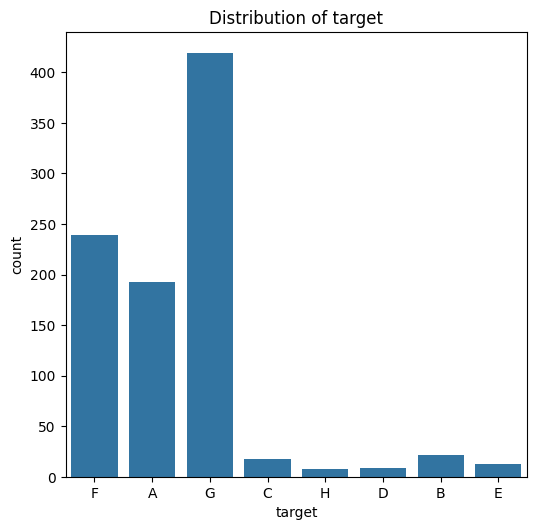

In [473]:
# Distribution plot for target column
object_columns = ["target"]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(object_columns):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=df[feature], data=df)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Dataset Description;


| S.No. | Feature Name           | Description                                                 | Data Type |
|-------|------------------------|-------------------------------------------------------------|-----------|
| 1     | age                    | age of the patient                                          | int       |
| 2     | sex                    | sex patient identifies                                      | str       |
| 3     | on_thyroxine           | whether patient is on thyroxine                             | bool      |
| 5     | on_antithyroid_meds    | Whether patient is on antithyroid meds                      | bool      |
| 6     | sick                   | Whether patient is sick                                     | bool      |
| 7     | pregnant               | Whether patient is pregnant                                 | bool      |
| 8     | thyroid_surgery        | Whether patient has undergone thyroid surgery               | bool      |
| 9     | I131_treatment         | Whether patient is undergoing I131 treatment                | bool      |
| 10    | query_hypothyroid      | Whether patient believes they have hypothyroid              | bool      |
| 11    | query_hyperthyroid     | Whether patient believes they have hyperthyroid             | bool      |
| 12    | lithium                | Whether patient use lithium. This will cause goiter and hypothyroidism                               | bool      |
| 13    | goitre                 | Whether patient has goitre. It is an abnormal enlargement of the thyroid gland | bool      |
| 14    | tumor                  | Whether patient has tumor                                   | bool      |
| 15    | hypopituitary          | Whether patient has a hypopituitary gland                   | float     |
| 16    | psych                  | Whether patient has psych issues                            | bool      |
| 17    | TSH_measured           | Whether TSH was measured in the blood                       | bool      |
| 18    | TSH                    | TSH level in blood from lab work                            | float     |
| 19    | T3_measured            | Whether T3 was measured in the blood                        | bool      |
| 20    | T3                     | T3 level in blood from lab work                             | float     |
| 21    | TT4_measured           | Whether TT4 was measured in the blood                       | bool      |
| 22    | TT4                    | TT4 level in blood from lab work                            | float     |
| 23    | T4U_measured           | Whether T4U was measured in the blood                       | bool      |
| 24    | T4U                    | T4U level in blood from lab work                            | float     |
| 25    | FTI_measured           | Whether FTI was measured in the blood                       | bool      |
| 26    | FTI                    | FTI level in blood from lab work                            | float     |
| 27    | TBG_measured           | Whether TBG was measured in the blood                       | bool      |
| 28    | TBG                    | TBG level in blood from lab work                            | float     |
| 29    | referral_source        | Referral source                                             | str       |
| 30    | patient_id             | Unique ID of the patient                                    | str       |


Target:
 	* target - hyperthyroidism medical diagnosis (str)

we are going to define user have Hypothyroid or Hyperthyroid and their conditions (Totally 8 classifications).

            1. hyperthyroid conditions:
                1) A   Subclinical (initial)
                2) B   T3 toxic
                3) C   toxic goitre
                4) D   secondary toxic

            2. hypothyroid conditions:
                5) E   Subclinical (initial)
                6) F   primary hypothyroid
                7) G   compensated hypothyroid
                8) H   secondary hypothyroid


In our dataset;
* There are 920 rows and 31 columns,
* Number of object columns: 23,
* Number of numeric columns: 8,
* There one duplicate,
* Null values:

    | Column | Total Nulls | Percentage |
    |--------|-------------|------------|
    | TBG    | 912         | 99.130435  |
    | T3     | 200         | 21.739130  |
    | T4U    | 55          | 5.978261   |
    | FTI    | 54          | 5.869565   |
    | TSH    | 47          | 5.108696   |
    | sex    | 42          | 4.565217   |
    | TT4    | 9           | 0.978261   |



For preprocess the data we are going to;
1. Drop unwanted columns (patient_id) and duplicates
2. Handle Null values:
    * Drop TBG	column. Beacause it contains 912 null values which means 99% null values.
    * Fill or replace T3, TSH, T4U, FTI, TT4, sex columns with mean, median or mode.
3. Implement BOOST balancing method to balance the data.
4. Implement Labelencoding to convert object type columns into numeric columns.

# # Data Preprocessing

### 1. Drop unwanted columns
patient_id column is no need. So we can drop that column.

In [474]:
df.drop(["patient_id"], axis=1, inplace=True)

In [475]:
df.drop_duplicates(inplace=True)

### 2. Handle null values

Drop TBG column. Beacause it contains 912 null values which means 99% null values.

In [476]:
df.drop(["TBG"], axis=1, inplace=True)

Fill or replace T3, TSH, T4U, FTI, TT4, sex columns with mean, median or mode.

In [477]:
import pandas as pd
import numpy as np

def fill_nulls_with_random(df):
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    
    # Loop through each numerical column
    for col in numerical_columns:
        # Check for null values
        if df[col].isnull().sum() > 0:
            # Get lower and upper bounds (min and max of non-null values)
            lower_bound = df[col].min()
            upper_bound = df[col].max()
            
            # Generate random numbers to fill the null values
            # We only generate numbers for the number of NaNs in the column
            random_values = np.random.uniform(lower_bound, upper_bound, df[col].isnull().sum())
            
            # Fill NaN values with generated random numbers
            df.loc[df[col].isnull(), col] = random_values
    
    return df

df_filled = fill_nulls_with_random(df)

In [478]:
# Filter for object (categorical) columns
object_df = df.select_dtypes(include='object')

# Function to fill null values with random values from unique values of the column
def fill_na_with_random_choice(column):
    if column.isnull().any():  # Check if there are NaNs in the column
        unique_values = column.dropna().unique()  # Get unique values, excluding NaNs
        if len(unique_values) > 0:
            # Generate random choices for each NaN
            random_choices = np.random.choice(unique_values, size=column.isnull().sum())
            column.fillna(pd.Series(random_choices, index=column[column.isnull()].index), inplace=True)

# Apply the function to each object column
for col in object_df.columns:
    fill_na_with_random_choice(df[col])

### 3. Label Encoding

In [479]:
# Filter for object (categorical) columns
object_df = df.select_dtypes(include='object')

# Identify object columns with fewer than 2 unique values
columns_with_fewer_than_two_classes = [
    col for col in object_df.columns
    if object_df[col].nunique() < 2
]

print("Object columns with fewer than 2 unique values:\n", columns_with_fewer_than_two_classes)

Object columns with fewer than 2 unique values:
 []


In [480]:
#label encoding the object data.

from sklearn.preprocessing import LabelEncoder

# Store original column names
original_columns = df.select_dtypes(include='object').columns

# Initialize LabelEncoder
label_encoders = {}

# Apply LabelEncoder to each categorical variable
for col in original_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Print the mapping between original categories and numerical labels
for col, encoder in label_encoders.items():
    print(f"Mapping for column '{col}':")
    for label, category in enumerate(encoder.classes_):
        print(f"Label {label}: {category}")
    print("===============================")

Mapping for column 'sex':
Label 0: F
Label 1: M
Mapping for column 'on_thyroxine':
Label 0: f
Label 1: t
Mapping for column 'query_on_thyroxine':
Label 0: f
Label 1: t
Mapping for column 'on_antithyroid_meds':
Label 0: f
Label 1: t
Mapping for column 'sick':
Label 0: f
Label 1: t
Mapping for column 'pregnant':
Label 0: f
Label 1: t
Mapping for column 'thyroid_surgery':
Label 0: f
Label 1: t
Mapping for column 'I131_treatment':
Label 0: f
Label 1: t
Mapping for column 'query_hypothyroid':
Label 0: f
Label 1: t
Mapping for column 'query_hyperthyroid':
Label 0: f
Label 1: t
Mapping for column 'lithium':
Label 0: f
Label 1: t
Mapping for column 'goitre':
Label 0: f
Label 1: t
Mapping for column 'tumor':
Label 0: f
Label 1: t
Mapping for column 'hypopituitary':
Label 0: f
Label 1: t
Mapping for column 'psych':
Label 0: f
Label 1: t
Mapping for column 'TSH_measured':
Label 0: f
Label 1: t
Mapping for column 'T3_measured':
Label 0: f
Label 1: t
Mapping for column 'TT4_measured':
Label 0: f
La

### Correlation Matrix

Correlation Matrix:
                           age       sex  on_thyroxine  query_on_thyroxine  \
age                  1.000000 -0.051161     -0.049159           -0.083460   
sex                 -0.051161  1.000000     -0.038449           -0.061195   
on_thyroxine        -0.049159 -0.038449      1.000000           -0.021242   
query_on_thyroxine  -0.083460 -0.061195     -0.021242            1.000000   
on_antithyroid_meds  0.027288  0.026327     -0.022199           -0.012660   
sick                 0.059579  0.028753      0.037613           -0.018781   
pregnant            -0.127798 -0.037635      0.032536           -0.012115   
thyroid_surgery     -0.021535 -0.041122     -0.014274           -0.008141   
I131_treatment      -0.003301  0.004872      0.011296           -0.016417   
query_hypothyroid    0.114888 -0.049793      0.045922            0.016326   
query_hyperthyroid  -0.106826 -0.034639     -0.057854           -0.042859   
lithium             -0.040562  0.039699     -0.016908  

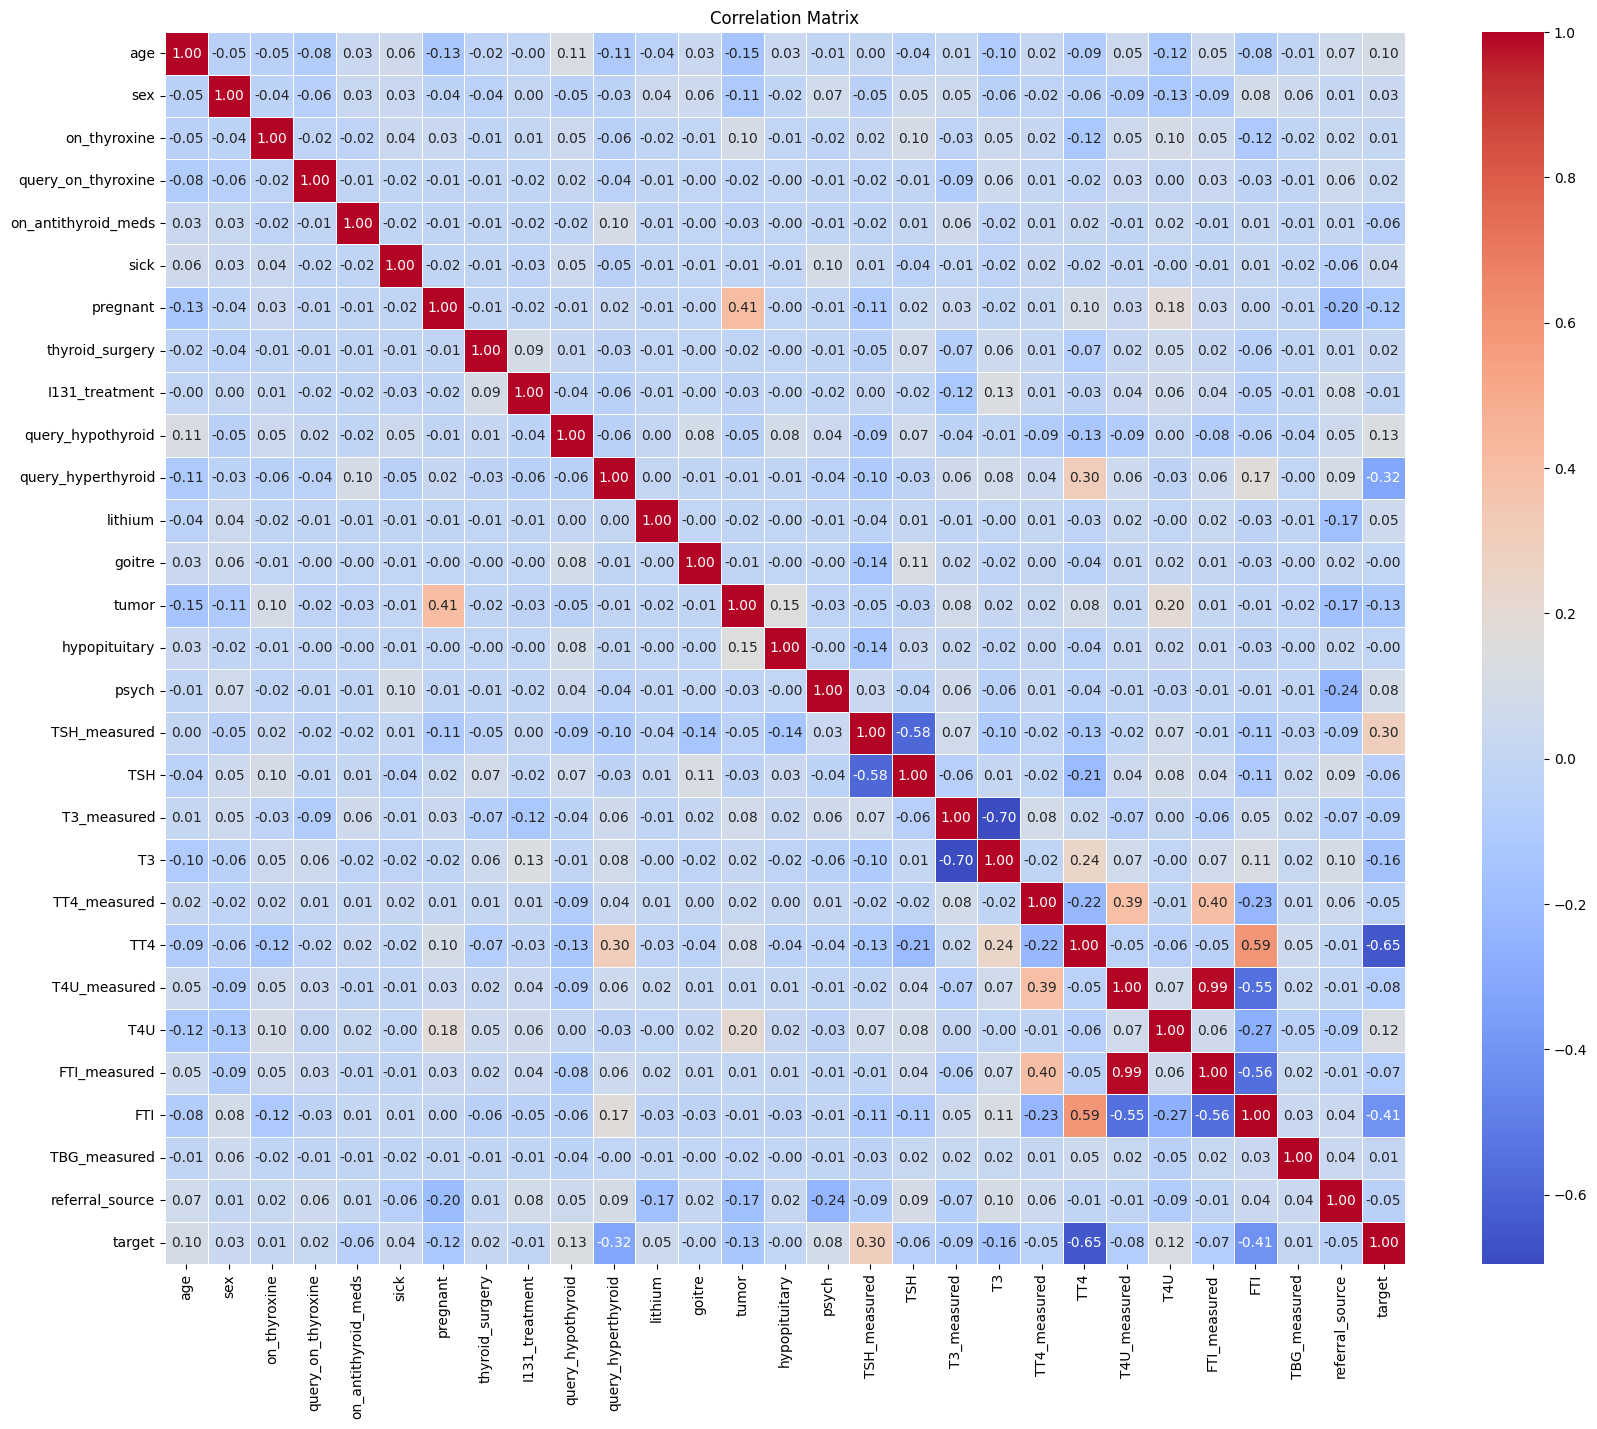

In [481]:
# correlation matrix
correlation_matrix = df.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [482]:
X = df.drop(["target"], axis=1)
y = df["target"]

In [483]:
from sklearn.feature_selection import SelectKBest, f_classif

# Initialize SelectKBest with the desired scoring function and k=10 (10 best features)
selector = SelectKBest(score_func=f_classif, k=10)

# Fit the selector
selector.fit(X, y)

# Get the feature scores for each feature
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame with feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores,
    'P-Value': p_values
})

# Sort the DataFrame by Score in descending order
feature_scores_sorted = feature_scores.sort_values(by='Score', ascending=False)

# top 10 features
top_10_features = feature_scores_sorted.head(10)

# Retrieve the column names of the top 10 features
top_10_feature_names = top_10_features['Feature'].tolist()

# Filter the original DataFrame to include only the top 10 features
df_top_10 = df[top_10_feature_names]

In [484]:
# view thedataframe
df_top_10

,TT4,tumor,FTI,TSH_measured,pregnant,TSH,query_hyperthyroid,T4U,on_antithyroid_meds,query_hypothyroid
0,48.0,0,47.0,1,0,68.000000,0,1.02,0,0
1,157.0,0,176.0,1,0,0.050000,0,0.89,0,0
2,33.0,0,31.0,1,0,140.000000,0,1.07,0,0
3,114.0,0,136.0,1,0,9.799999,0,0.84,0,0
4,7.5,0,7.5,1,0,90.000000,0,0.94,0,0
...,...,...,...,...,...,...,...,...,...,...
914,16.0,0,15.0,0,0,142.554587,0,1.10,0,1
916,16.0,0,15.0,0,0,482.851302,1,1.10,0,1
917,16.0,0,15.0,0,0,328.322221,0,1.10,0,1
918,16.0,0,15.0,0,0,362.792842,0,1.10,0,1


### 3. BOO-ST balance method to balance the imbalace data

BOOST :=>
* BS(Boosting with Sample Weighting), 
* SMOTE (Synthetic Minority Over-sampling Technique),
* Tomek Links (TL)

In [485]:
# Split the data Into X and y (X has all features and y has target variable)
X = df_top_10
y = y

In [486]:
# Import required libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification

In [487]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [488]:
# Step 1: Apply Boosting Stage (BS)
# Initialize AdaBoost Classifier with Decision Tree as base estimator
boosting_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42)
boosting_model.fit(X_train, y_train)

c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=100, random_state=42)

In [489]:
# Step 2: Apply SMOTE for oversampling minority class
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [490]:
# Step 3: Apply Tomek Links to remove noisy samples
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_smote, y_smote)

In [491]:
# Convert the resampled data into DataFrames
X_train_res_df = pd.DataFrame(X_resampled, columns=X_train.columns)
y_train_res_df = pd.DataFrame(y_resampled, columns=[y_train.name])  # y_train.name preserves the original target column name

# Combine the features and target into one DataFrame (preprocessed data)
df = pd.concat([X_train_res_df, y_train_res_df], axis=1)

In [492]:
# view the preprocessed data
df

,TT4,tumor,FTI,TSH_measured,pregnant,TSH,query_hyperthyroid,T4U,on_antithyroid_meds,query_hypothyroid,target
0,210.000000,0,241.000000,1,0,0.065000,1,0.870000,0,0,0
1,117.000000,0,113.000000,1,0,6.700000,0,1.040000,0,0,6
2,148.000000,0,134.000000,1,0,19.000000,0,1.110000,0,0,6
3,76.000000,0,75.000000,1,0,7.900000,0,1.010000,0,0,6
4,63.000000,0,59.000000,1,0,178.000000,0,1.080000,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...
2311,49.515442,0,59.707846,1,0,4.493823,0,0.829691,0,0,7
2312,37.487110,0,72.283891,1,0,3.504366,0,0.581145,0,0,7
2313,28.341834,0,46.780611,1,0,2.623533,0,0.592353,0,0,7
2314,32.519638,0,48.173213,1,0,3.267611,0,0.656761,0,0,7


In [493]:
# remove duplicates
print("Duplicates before drop:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Duplicates before drop:", df.duplicated().sum())

Duplicates before drop: 3
Duplicates before drop: 0


In [494]:
# null counts
df.isnull().sum()

TT4                    0
tumor                  0
FTI                    0
TSH_measured           0
pregnant               0
TSH                    0
query_hyperthyroid     0
T4U                    0
on_antithyroid_meds    0
query_hypothyroid      0
target                 0
dtype: int64

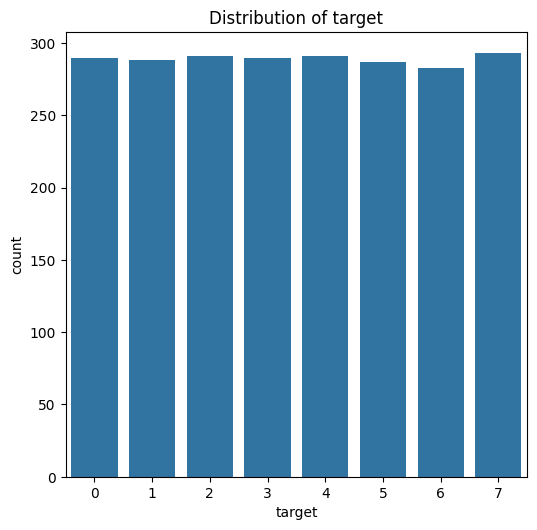

In [495]:
# Distribution plot for target column to check the whether the data balanced or not
object_columns = ["target"]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(object_columns):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=df[feature], data=df)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Our preprocessed data is a balanced dataset

In [496]:
# information about preprocessde data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2313 entries, 0 to 2315
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TT4                  2313 non-null   float64
 1   tumor                2313 non-null   int32  
 2   FTI                  2313 non-null   float64
 3   TSH_measured         2313 non-null   int32  
 4   pregnant             2313 non-null   int32  
 5   TSH                  2313 non-null   float64
 6   query_hyperthyroid   2313 non-null   int32  
 7   T4U                  2313 non-null   float64
 8   on_antithyroid_meds  2313 non-null   int32  
 9   query_hypothyroid    2313 non-null   int32  
 10  target               2313 non-null   int32  
dtypes: float64(4), int32(7)
memory usage: 153.6 KB


In [497]:
# information about preprocessed data
df.describe()

,TT4,tumor,FTI,TSH_measured,pregnant,TSH,query_hyperthyroid,T4U,on_antithyroid_meds,query_hypothyroid,target
count,2313.000000,2313.000000,2313.000000,2313.000000,2313.000000,2313.000000,2313.000000,2313.000000,2313.000000,2313.000000,2313.000000
mean,103.180285,0.132728,141.228662,0.815824,0.021185,65.392067,0.116732,0.995574,0.011241,0.123217,3.496757
std,73.240390,0.339354,148.213497,0.387712,0.144031,125.115035,0.321170,0.263089,0.105448,0.328757,2.293007
min,2.000000,0.000000,1.400000,0.000000,0.000000,0.005000,0.000000,0.280000,0.000000,0.000000,0.000000
25%,44.691763,0.000000,53.482249,1.000000,0.000000,0.411432,0.000000,0.842636,0.000000,0.000000,2.000000
50%,107.000000,0.000000,98.534390,1.000000,0.000000,6.890110,0.000000,0.995866,0.000000,0.000000,3.000000
75%,141.965355,0.000000,171.000000,1.000000,0.000000,38.000000,0.000000,1.110000,0.000000,0.000000,5.000000
max,430.000000,1.000000,803.658951,1.000000,1.000000,530.000000,1.000000,1.830000,1.000000,1.000000,7.000000


After preprocessing the data we have;
* No duplicates,
* No null values,
* No object columns (Converted all object into numeric type using label encoding)
* Balanced dataset

Now we can go for Algorithm implementation

In [498]:
# # Save preprocessed data as a csv file for web application use
# df.to_csv("DATASET/Final_Dataset.csv")

# # Data Splitting

In [499]:
# Split the data into features and target
X = df.drop("target", axis=1) # Features
y = df["target"] # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [500]:
# Traing features
X_train

,TT4,tumor,FTI,TSH_measured,pregnant,TSH,query_hyperthyroid,T4U,on_antithyroid_meds,query_hypothyroid
140,11.000000,0,8.900000,1,0,160.000000,0,1.240000,0,0
129,181.000000,0,174.000000,0,0,156.279310,1,1.040000,0,0
588,162.000000,0,200.000000,0,0,522.848447,0,0.810000,0,0
1404,131.185876,0,472.534309,1,0,8.048833,0,0.280000,0,0
759,230.762681,0,174.220362,1,0,0.094068,0,1.334237,0,0
...,...,...,...,...,...,...,...,...,...,...
941,117.670178,0,123.715791,1,0,0.120175,0,0.949544,0,0
959,73.413487,0,70.414661,1,0,0.185425,0,1.019155,0,0
436,50.000000,0,43.000000,1,0,55.000000,0,1.170000,0,0
220,93.000000,0,77.000000,1,0,19.000000,0,1.200000,0,1


In [501]:
# Traing target
y_train

140     5
129     0
588     0
1404    3
759     0
       ..
941     1
959     1
436     5
220     6
111     1
Name: target, Length: 1619, dtype: int32

In [502]:
# testing features
X_test

,TT4,tumor,FTI,TSH_measured,pregnant,TSH,query_hyperthyroid,T4U,on_antithyroid_meds,query_hypothyroid
2085,47.263362,0,54.475693,1,0,5.507901,0,0.874653,0,0
265,78.000000,0,85.000000,1,0,23.000000,0,0.920000,0,0
1090,117.830119,1,106.245178,1,0,0.865798,0,1.105849,0,0
816,142.889530,0,115.296510,1,0,0.027791,0,1.235930,0,0
2061,50.695784,0,58.216862,1,0,1.377706,0,0.868705,0,0
...,...,...,...,...,...,...,...,...,...,...
2296,51.489095,0,71.217947,1,0,4.619092,0,0.789574,0,0
1196,155.121239,1,107.121239,0,1,9.177302,0,1.449394,0,0
1753,16.000000,0,15.000000,0,0,220.332092,0,1.100000,0,0
819,124.395733,0,127.834541,1,0,0.026115,1,0.977267,0,0


In [503]:
# testing target
y_test

2085    7
265     6
1090    2
816     1
2061    7
       ..
2296    7
1196    2
1753    4
819     1
1338    3
Name: target, Length: 694, dtype: int32

# # Algorithm Impementation

In [504]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [505]:
# Define the classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

" Permutation Feature Importance (PFI) is a method used to evaluate the importance of features in a machine learning model. "

In [506]:
# Step 1: Train all classifiers and compute Permutation Feature Importance (PFI)
pfi_results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    pfi = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
    pfi_results[name] = np.mean(pfi.importances_mean)
    print(f"Classifier: {name}, PFI Score: {pfi_results[name]}")

Classifier: Decision Tree, PFI Score: 0.1629894996911674
Classifier: SVM, PFI Score: 0.10217418159357627
Classifier: KNN, PFI Score: 0.13772699197035204
Classifier: Random Forest, PFI Score: 0.111550339715874


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classifier: AdaBoost, PFI Score: 0.016553428042001238
Classifier: Gradient Boosting, PFI Score: 0.12163681284743669


In [507]:
# Step 2: Select Half-Most Effective Classifiers (HEC) based on PFI
sorted_classifiers = sorted(pfi_results.items(), key=lambda x: x[1], reverse=True)
hec_classifiers = [name for name, _ in sorted_classifiers[:len(sorted_classifiers) // 2]]
print(f"Selected HEC Classifiers: {hec_classifiers}")

Selected HEC Classifiers: ['Decision Tree', 'KNN', 'Gradient Boosting']


In [508]:
# Step 3: Define the ensemble methods using the selected classifiers
estimators = [(name, classifiers[name]) for name in hec_classifiers]

# Define ensemble methods
boosting = AdaBoostClassifier(estimator=estimators[0][1])
bagging = BaggingClassifier(estimator=estimators[0][1])
voting = VotingClassifier(estimators=estimators, voting='soft')
stacking = StackingClassifier(estimators=estimators)

ensemble_methods = {
    'Boosting': boosting,
    'Bagging': bagging,
    'Voting': voting,
    'Stacking': stacking
}

In [509]:
# Step 4: Train each ensemble method and evaluate accuracy
accuracy_results = {}
for name, ensemble in ensemble_methods.items():
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results[name] = accuracy
    print(f"Ensemble Method: {name}, Accuracy: {accuracy}")

Ensemble Method: Boosting, Accuracy: 0.9913544668587896
Ensemble Method: Bagging, Accuracy: 0.9927953890489913


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Ensemble Method: Voting, Accuracy: 0.9913544668587896
Ensemble Method: Stacking, Accuracy: 0.9884726224783862


In [510]:
# Step 5: Select Most Efficient Ensemble Method (EEM)
best_ensemble = max(accuracy_results, key=accuracy_results.get)
print(f"Most Efficient Ensemble Method: {best_ensemble}")

Most Efficient Ensemble Method: Bagging


Training Accuracy for Bagging: 0.9994
Testing Accuracy for Bagging: 0.9928

Classification Report for Bagging:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00        87
           2       0.99      1.00      0.99        87
           3       0.97      1.00      0.98        87
           4       1.00      1.00      1.00        87
           5       1.00      0.99      0.99        86
           6       0.99      0.95      0.97        85
           7       1.00      1.00      1.00        88

    accuracy                           0.99       694
   macro avg       0.99      0.99      0.99       694
weighted avg       0.99      0.99      0.99       694



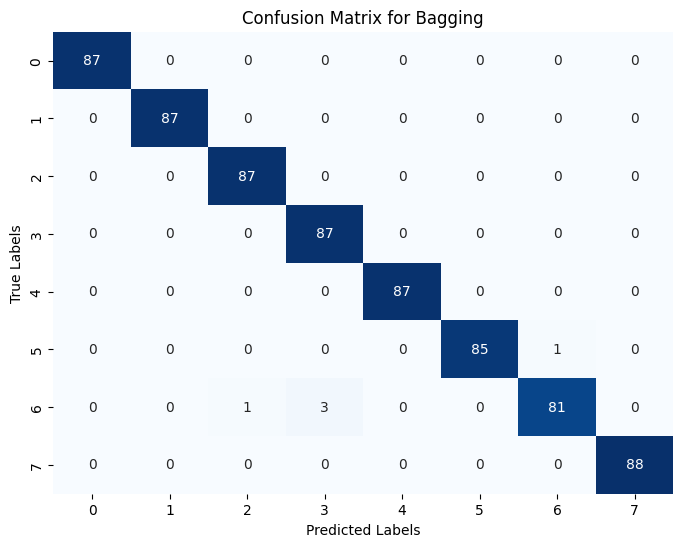

In [511]:
# Build the final model
from sklearn.metrics import classification_report, accuracy_score

# Retrieve the best model
best_model = ensemble_methods[best_ensemble]

# Make predictions with the best model on the test set
y_pred = best_model.predict(X_test)

# Calculate training accuracy
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy for {best_ensemble}: {train_accuracy:.4f}")

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy for {best_ensemble}: {test_accuracy:.4f}")

# Generate the classification report
report = classification_report(y_test, y_pred)
print(f"\nClassification Report for {best_ensemble}:")
print(report)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix for {best_ensemble}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Save Model

In [512]:
# saving the model
import joblib

joblib.dump(best_model, 'MODELS/best_ensemble_model.pkl')
print("Best model saved as 'best_ensemble_model.pkl'")

Best model saved as 'best_ensemble_model.pkl'


# # Prediction Part

In [513]:
import joblib

# Load the saved model
model = joblib.load('MODELS/best_ensemble_model.pkl')

# Define class mappings
condition_class = {
    0: "Subclinical (initial level)", 
    1: "T3 toxic", 
    2: "toxic goitre", 
    3: "secondary toxic", 
    4: "Subclinical (initial level)",
    5: "primary hypothyroid",
    6: "compensated hypothyroid",
    7: "secondary hypothyroid",
}

disorder_class = {
    0: "hyperthyroid", 
    1: "hyperthyroid", 
    2: "hyperthyroid", 
    3: "hyperthyroid", 
    4: "hypothyroid",
    5: "hypothyroid",
    6: "hypothyroid",
    7: "hypothyroid",
}

# Prediction Function
def prediction_func(input_features):
    input_array = np.array([input_features])
    
    # Make prediction
    prediction = model.predict(input_array)
    
    # Convert prediction to class label
    predicted_class = prediction[0]

    # Map the class label to disorder and condition
    predicted_disorder = disorder_class[predicted_class]
    predicted_condition = condition_class[predicted_class]
    
    print(f"Predicted Disorder: {predicted_disorder}")
    print(f"Predicted Condition: {predicted_condition}")

In [524]:
# Sample input for hyperthyroid (Subclinical)
prediction_func([160.000000, 0, 204.000000, 1, 0, 0.030000, 0, 0.780000, 0, 0])

Predicted Disorder: hyperthyroid
Predicted Condition: Subclinical (initial level)


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [525]:
# Sample input for hyperthyroid (T3 toxic)
prediction_func([140.489084, 0, 117.644102, 1, 0, 0.030775, 0, 1.192227, 0, 0])

Predicted Disorder: hyperthyroid
Predicted Condition: T3 toxic


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [526]:
# Sample input for hyperthyroid (toxic goitre)
prediction_func([117.830119, 1, 106.245178, 1, 0, 0.865798, 0, 1.105849, 0, 0])

Predicted Disorder: hyperthyroid
Predicted Condition: toxic goitre


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [527]:
# Sample input for hyperthyroid (secondary toxic)
prediction_func([131.975559, 0, 487.814102, 1, 0, 7.953860, 0, 0.294808, 0, 0])

Predicted Disorder: hyperthyroid
Predicted Condition: secondary toxic


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [529]:
# Sample input for hypothyroid (Subclinical)
prediction_func([16.000000, 0, 15.000000, 0, 0, 298.456436, 0, 1.100000, 0, 1])

Predicted Disorder: hypothyroid
Predicted Condition: Subclinical (initial level)


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [530]:
# Sample input for hypothyroid (primary hypothyroid)
prediction_func([3.900000, 0, 5.000000, 1, 0, 70.000000, 0, 0.830000, 0, 0])

Predicted Disorder: hypothyroid
Predicted Condition: primary hypothyroid


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [531]:
# Sample input for hypothyroid (compensated hypothyroid)
prediction_func([78.000000, 0, 85.000000, 1, 0, 23.000000, 0, 0.920000, 0, 0])

Predicted Disorder: hypothyroid
Predicted Condition: compensated hypothyroid


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [532]:
# Sample input for hypothyroid (secondary hypothyroid)
prediction_func([47.263362, 0, 54.475693, 1, 0, 5.507901, 0, 0.874653, 0, 0])

Predicted Disorder: hypothyroid
Predicted Condition: secondary hypothyroid


c:\Users\0877\.conda\envs\tk159645\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [533]:
# samples
X_test.head(50)

,TT4,tumor,FTI,TSH_measured,pregnant,TSH,query_hyperthyroid,T4U,on_antithyroid_meds,query_hypothyroid
2085,47.263362,0,54.475693,1,0,5.507901,0,0.874653,0,0
265,78.000000,0,85.000000,1,0,23.000000,0,0.920000,0,0
1090,117.830119,1,106.245178,1,0,0.865798,0,1.105849,0,0
816,142.889530,0,115.296510,1,0,0.027791,0,1.235930,0,0
2061,50.695784,0,58.216862,1,0,1.377706,0,0.868705,0,0
1796,16.000000,0,15.000000,0,0,298.456436,0,1.100000,0,1
945,140.489084,0,117.644102,1,0,0.030775,0,1.192227,0,0
440,120.000000,0,154.000000,0,0,416.610656,1,0.780000,0,0
612,160.000000,0,204.000000,1,0,0.030000,0,0.780000,0,0
44,184.000000,0,177.000000,1,0,0.005000,0,1.030000,0,0


In [534]:
y_test.head(50)

2085    7
265     6
1090    2
816     1
2061    7
1796    4
945     1
440     1
612     0
44      0
2280    7
1208    2
1186    2
498     5
1979    5
2136    7
1193    2
2070    7
1400    3
136     5
1792    4
808     1
1275    2
951     1
897     1
2120    7
1344    3
407     2
1914    5
1884    4
594     4
2238    7
965     1
867     1
168     6
1135    2
1520    3
2167    7
1641    4
492     5
1385    3
739     0
514     5
369     6
1235    2
1311    2
1928    5
1189    2
1098    2
1929    5
Name: target, dtype: int32